# Store Demand Forecasting

#### Imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

#### Seaborn settings

In [4]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [20, 9]

## EDA

We will start with a short introspection into the dataset.

Remember to change the path if you'd like to replicate the results.

In [5]:
DATA_PATH = "/home/mstankiewicz/projects/store_demand_forecasting/data/"
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df["date"] = pd.to_datetime(df["date"])

Check the date ranges for all stores

In [44]:
df.groupby("store").agg({'date': [np.min, np.max]})

date           
            amin       amax
store                      
1     2013-01-01 2017-12-31
2     2013-01-01 2017-12-31
3     2013-01-01 2017-12-31
4     2013-01-01 2017-12-31
5     2013-01-01 2017-12-31
6     2013-01-01 2017-12-31
7     2013-01-01 2017-12-31
8     2013-01-01 2017-12-31
9     2013-01-01 2017-12-31
10    2013-01-01 2017-12-31

See how many missing values we have

In [45]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Good! No missing values. We have a complete dataset for all stores.

Let's focus on a single store and see how the sales look.

I also did a store by store analysis to see if there are any outliers. I saw that charts for the stores are very similar, so I decided to leave them out for the sake of clarity in this analysis.

In [6]:
store_df_full = df[df["store"] == 1]
store_df_full = store_df_full[["date", "sales"]]

In [7]:
grouped_store_df_full = store_df_full.groupby("date").mean().sort_index()

I will use  `statsmodel` library to analyze standard parameters for a single variable time series: trend, seasonality, residual variables.

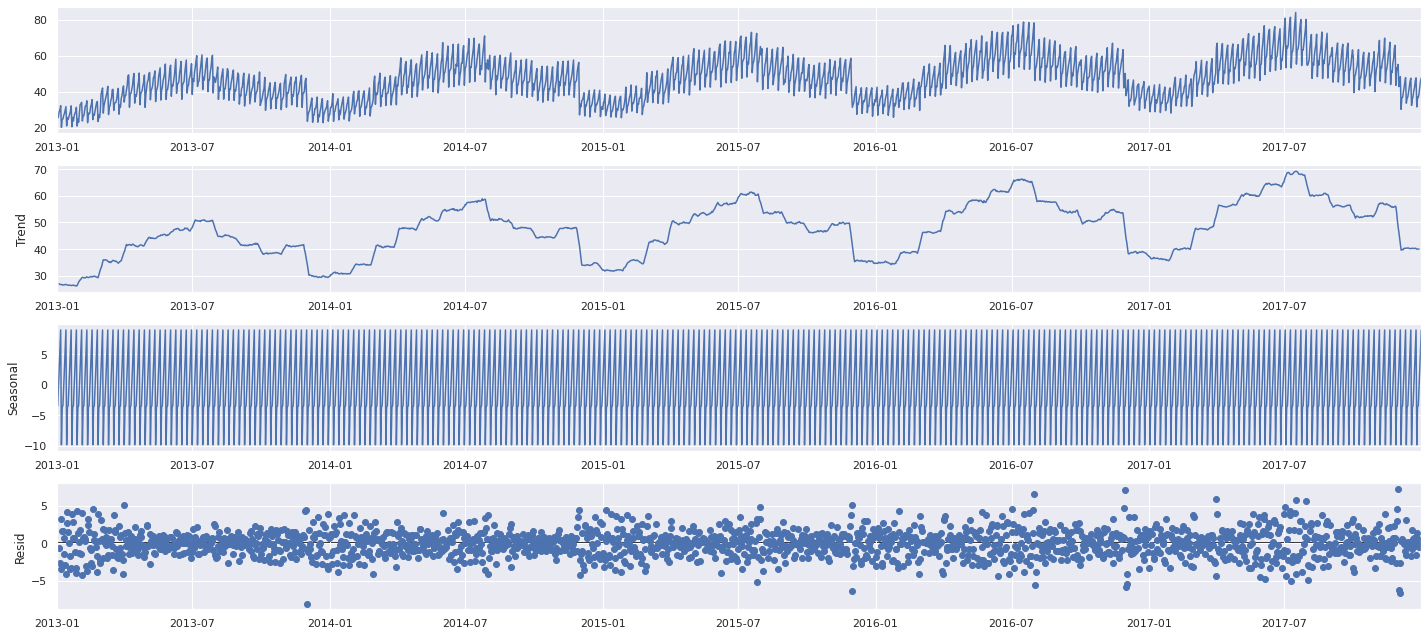

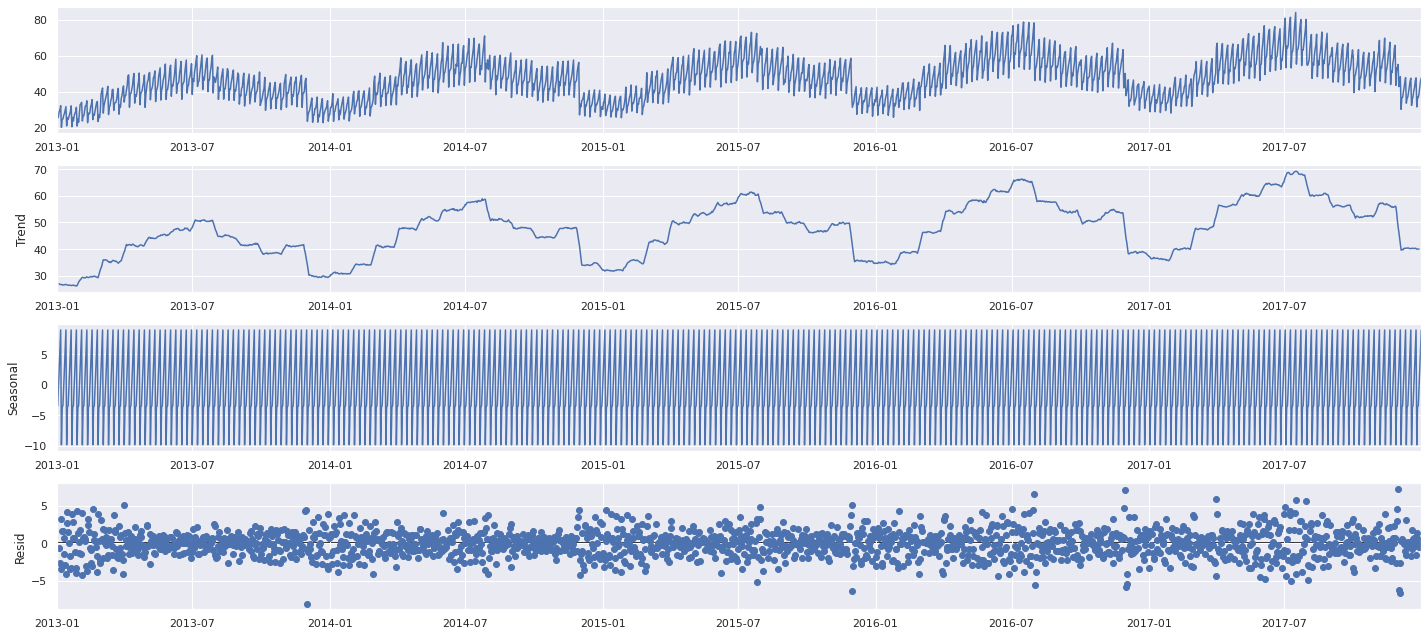

In [8]:
result = seasonal_decompose(grouped_store_df_full, model='additive')
result.plot()

We definitely have a similar, repeating trend. We should confirm it by looking at seasonality chart, but in this scale there is very little to see. Let's focus on a smaller time-frame.

### Smaller Scale

In [9]:
store_df = df[df["store"] == 1]
store_df = store_df[store_df["date"] <= "2014-12-31"]

In [10]:
store_df = store_df[["date", "sales"]]
store_df

date  sales
0      2013-01-01     13
1      2013-01-02     11
2      2013-01-03     14
3      2013-01-04     13
4      2013-01-05     10
...           ...    ...
895465 2014-12-27     44
895466 2014-12-28     55
895467 2014-12-29     29
895468 2014-12-30     37
895469 2014-12-31     39

[36500 rows x 2 columns]

In [11]:
grouped_df = store_df.groupby("date").mean().sort_index()

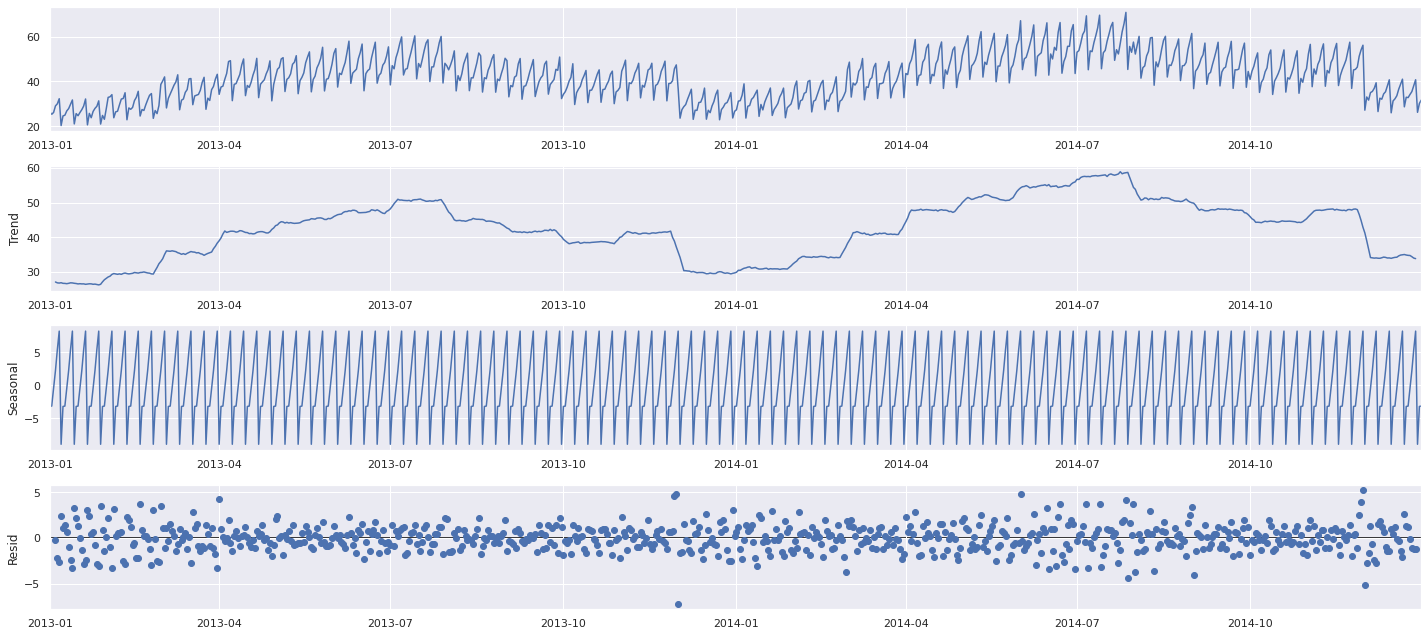

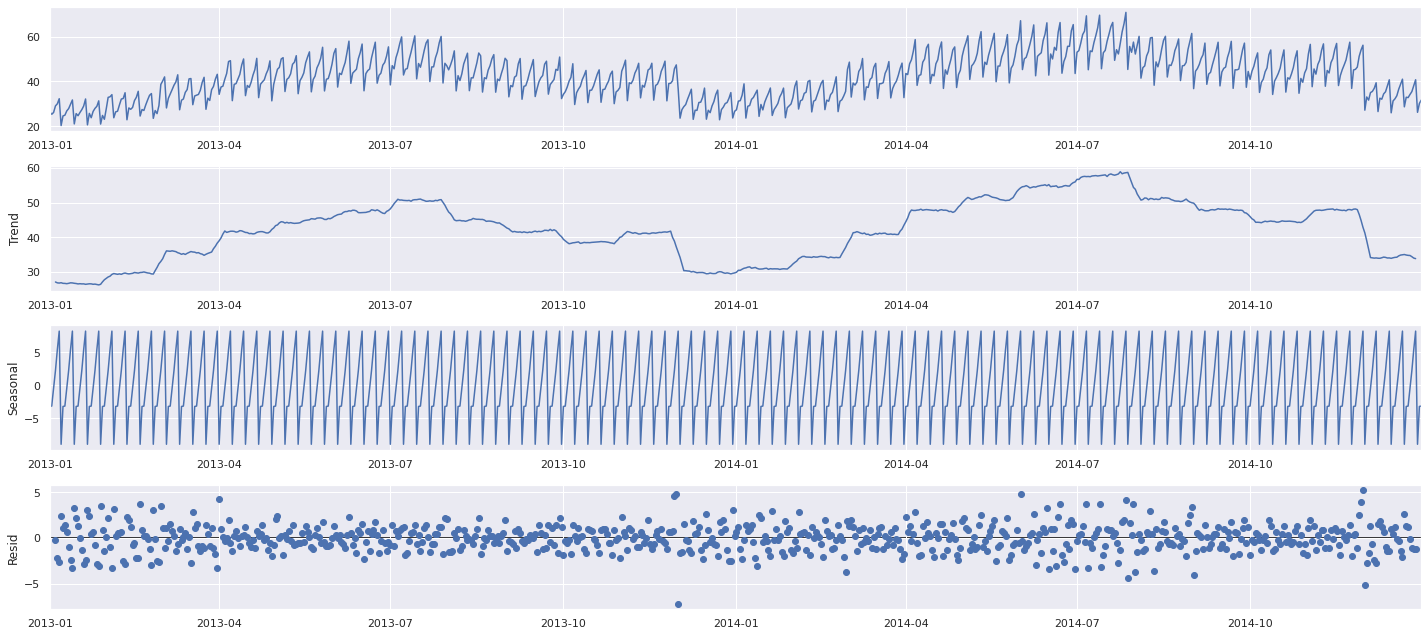

In [12]:
result = seasonal_decompose(grouped_df, model='additive')
result.plot()

Now we can clearly see the seasonal pattern visible in the data.

## Building a model

### Feature engineering

I decided, mostly guided by experience, to split date into single values representing year, month and day. Also I added day of week and week of year to catch possible repeating patterns in a weekly/yearly scale.

In [13]:
df2 = df.copy()
df2["year"] = df2["date"].dt.year
df2["month"] = df2["date"].dt.month
df2["day"] = df2["date"].dt.day
df2["dayofweek"] = df2["date"].dt.dayofweek
df2["weekofyear"] = df2["date"].dt.isocalendar().week

I added exponential moving average (EMA) to smooth out the trend line for the model. It should also provide an insight into previous values. EMA is computed for each item in each store with a span of 20 days.
It is done in a somehow convoluted, and I am quite sure that non-optimal way, but it should do it's job for a POC.

In [14]:
ema = pd.DataFrame(index=df2.index, columns=["ema"])

for store in df2["store"].unique():
    for item in df2["item"].unique():
        sl = df2[(df2["store"] == store) & (df2["item"] == item)]
        expmean = sl["sales"].ewm(span=20).mean()
        ema["ema"].iloc[expmean.index] = expmean

df2["ema"] = ema["ema"]

In [15]:
cols= ["dayofweek", "weekofyear", "ema"]
df2[cols] = pd.to_numeric(df2[cols].stack(), errors='coerce').unstack()

In [16]:
df2.head(30)

date  store  item  sales  year  month  day  dayofweek  weekofyear  \
0  2013-01-01      1     1     13  2013      1    1        1.0         1.0   
1  2013-01-02      1     1     11  2013      1    2        2.0         1.0   
2  2013-01-03      1     1     14  2013      1    3        3.0         1.0   
3  2013-01-04      1     1     13  2013      1    4        4.0         1.0   
4  2013-01-05      1     1     10  2013      1    5        5.0         1.0   
5  2013-01-06      1     1     12  2013      1    6        6.0         1.0   
6  2013-01-07      1     1     10  2013      1    7        0.0         2.0   
7  2013-01-08      1     1      9  2013      1    8        1.0         2.0   
8  2013-01-09      1     1     12  2013      1    9        2.0         2.0   
9  2013-01-10      1     1      9  2013      1   10        3.0         2.0   
10 2013-01-11      1     1      9  2013      1   11        4.0         2.0   
11 2013-01-12      1     1      7  2013      1   12        5.0         2.0   
12 2013-01-13      1     1     10  2013      1   13        6.0         2.0   
13 2013-01-14      1     1     12  2013      1   14        0.0         3.0   
14 2013-01-15      1     1      5  2013      1   15        1.0         3.0   
15 2013-01-16      1     1      7  2013      1   16        2.0         3.0   
16 2013-01-17      1     1     16  2013      1   17        3.0         3.0   
17 2013-01-18      1     1      7  2013      1   18        4.0         3.0   
18 2013-01-19      1     1     18  2013      1   19        5.0         3.0   
19 2013-01-20      1     1     15  2013      1   20        6.0         3.0   
20 2013-01-21      1     1      8  2013      1   21        0.0         4.0   
21 2013-01-22      1     1      7  2013      1   22        1.0         4.0   
22 2013-01-23      1     1      9  2013      1   23        2.0         4.0   
23 2013-01-24      1     1      8  2013      1   24        3.0         4.0   
24 2013-01-25      1     1     14  2013      1   25        4.0         4.0   
25 2013-01-26      1     1     12  2013      1   26        5.0         4.0   
26 2013-01-27      1     1     12  2013      1   27        6.0         4.0   
27 2013-01-28      1     1     11  2013      1   28        0.0         5.0   
28 2013-01-29      1     1      6  2013      1   29        1.0         5.0   
29 2013-01-30      1     1      9  2013      1   30        2.0         5.0   

          ema  
0   13.000000  
1   11.950000  
2   12.702748  
3   12.788560  
4   12.114031  
5   12.089976  
6   11.694813  
7   11.229001  
8   11.352673  
9   10.998381  
10  10.713226  
11  10.207380  
12  10.180242  
13  10.410190  
14   9.747182  
15   9.419470  
16  10.186026  
17   9.822613  
18  10.738127  
19  11.207427  
20  10.859416  
21  10.446145  
22  10.293102  
23  10.052971  
24  10.462418  
25  10.620576  
26  10.761392  
27  10.785584  
28  10.303344  
29  10.172729

I saw that most of the other kernels/notebooks, that I looked through, used Facebook's Prophet library. Prophet is a great tool for time-series modelling and estimation, but I decided to not use it.  

Some of the other kernels focused on gradient boosting algorithms like LightGBM. I have more experience with XGBoost, so that's the tool that we will use today.

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

I used the 2017 year as a testing set and the rest of the dataset for training. It is probably overkill to use whole year for testing.

In [18]:
train_df = df2[df2["date"] <= "2016-12-31"]
test_df = df2[df2["date"] > "2016-12-31"]
print(len(train_df), len(test_df))

train_df = train_df.loc[:, train_df.columns != 'date']
test_df = test_df.loc[:, test_df.columns != 'date']

730500 182500


`sales` is our target column

In [19]:
x_train = train_df.loc[:, train_df.columns != 'sales']
y_train = train_df.loc[:, train_df.columns == 'sales']

In [20]:
x_test = test_df.loc[:, test_df.columns != 'sales']
y_test = test_df.loc[:, test_df.columns == 'sales']

Parameters are arbitrary, we will tune them later.

In [40]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 15)

In [41]:
xg_reg.fit(x_train,y_train)

preds = xg_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[20:00:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[20:00:12] INFO: /workspace/src/tree/upd

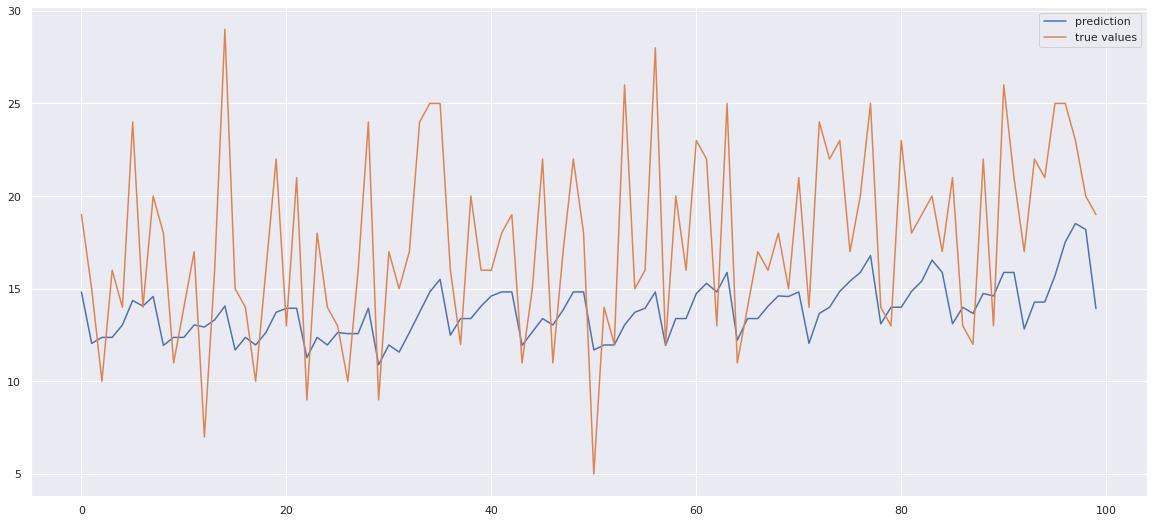

In [42]:
plt.plot(preds[:100], label="prediction")
plt.plot(y_test.to_numpy()[:100], label="true values")
plt.legend()

In the first try we were able to create a model that somewhat fit the curve, but the values are constantly too low and it cannot reproduce peak values. We can definitely do better.

### Hyperparameter Tuning

In [34]:
from sklearn.model_selection import GridSearchCV

We will do exhuastive/brute-force search for "the best" model parameters.

In [37]:
param_grid = [
  {
      'max_depth': [5, 7, 10, 15],
      'learning_rate': [0.1, 0.3, 0.5], 
      'n_estimators': [5, 15, 30]
  },
 ]

xreg = xgb.XGBRegressor(verbosity=2)

search = GridSearchCV(xreg, param_grid)

In [38]:
search.fit(x_train,y_train)

[19:44:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:38] INFO: /workspace/src/tree/upd

[19:44:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:49] INFO: /workspace/src/tree/upd

[19:44:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:44:59] INFO: /workspace/src/tree/upd

[19:45:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:45:09] INFO: /workspace/src/tree/upd

[19:45:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:23] INFO: /workspace/src/

[19:45:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:45:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:38] INFO: /workspace/src/

[19:45:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:45:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:45:52] INFO: /workspace/src/

[19:46:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:46:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:46:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:46:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:46:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:46:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:46:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:46:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:46:06] INFO: /workspace/src/

[19:46:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1758 extra nodes, 0 pruned nodes, max_depth=10
[19:46:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1782 extra nodes, 0 pruned nodes, max_depth=10
[19:46:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1888 extra nodes, 0 pruned nodes, max_depth=10
[19:46:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1906 extra nodes, 0 pruned nodes, max_depth=10
[19:46:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1130 extra nodes, 0 pruned nodes, max_depth=10
[19:46:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1216 extra nodes, 0 pruned nodes, max_depth=10
[19:46:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1270 extra nodes, 0 pruned nodes, max_depth=10
[19:46:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1372 extra nodes, 0 pruned nodes, max_depth=10
[19:46:25] INFO:

[19:46:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1966 extra nodes, 0 pruned nodes, max_depth=10
[19:46:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1960 extra nodes, 0 pruned nodes, max_depth=10
[19:46:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1942 extra nodes, 0 pruned nodes, max_depth=10
[19:46:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1970 extra nodes, 0 pruned nodes, max_depth=10
[19:46:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1912 extra nodes, 0 pruned nodes, max_depth=10
[19:46:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1952 extra nodes, 0 pruned nodes, max_depth=10
[19:46:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1972 extra nodes, 0 pruned nodes, max_depth=10
[19:46:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1900 extra nodes, 0 pruned nodes, max_depth=10
[19:46:45] INFO:

[19:47:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1864 extra nodes, 0 pruned nodes, max_depth=10
[19:47:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1892 extra nodes, 0 pruned nodes, max_depth=10
[19:47:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1850 extra nodes, 0 pruned nodes, max_depth=10
[19:47:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1842 extra nodes, 0 pruned nodes, max_depth=10
[19:47:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1826 extra nodes, 0 pruned nodes, max_depth=10
[19:47:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1150 extra nodes, 0 pruned nodes, max_depth=10
[19:47:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1230 extra nodes, 0 pruned nodes, max_depth=10
[19:47:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1302 extra nodes, 0 pruned nodes, max_depth=10
[19:47:05] INFO:

[19:47:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1830 extra nodes, 0 pruned nodes, max_depth=15
[19:47:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2256 extra nodes, 0 pruned nodes, max_depth=15
[19:47:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2702 extra nodes, 0 pruned nodes, max_depth=15
[19:47:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1436 extra nodes, 0 pruned nodes, max_depth=15
[19:47:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1588 extra nodes, 0 pruned nodes, max_depth=15
[19:47:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1996 extra nodes, 0 pruned nodes, max_depth=15
[19:47:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2378 extra nodes, 0 pruned nodes, max_depth=15
[19:47:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 3098 extra nodes, 0 pruned nodes, max_depth=15
[19:47:25] INFO:

[19:47:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20970 extra nodes, 0 pruned nodes, max_depth=15
[19:47:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1410 extra nodes, 0 pruned nodes, max_depth=15
[19:47:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1668 extra nodes, 0 pruned nodes, max_depth=15
[19:47:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1996 extra nodes, 0 pruned nodes, max_depth=15
[19:47:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2352 extra nodes, 0 pruned nodes, max_depth=15
[19:47:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2936 extra nodes, 0 pruned nodes, max_depth=15
[19:47:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 3542 extra nodes, 0 pruned nodes, max_depth=15
[19:47:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 4460 extra nodes, 0 pruned nodes, max_depth=15
[19:47:52] INFO

[19:48:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 4514 extra nodes, 0 pruned nodes, max_depth=15
[19:48:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5910 extra nodes, 0 pruned nodes, max_depth=15
[19:48:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 7464 extra nodes, 0 pruned nodes, max_depth=15
[19:48:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 9162 extra nodes, 0 pruned nodes, max_depth=15
[19:48:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 11148 extra nodes, 0 pruned nodes, max_depth=15
[19:48:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 13118 extra nodes, 0 pruned nodes, max_depth=15
[19:48:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 15458 extra nodes, 0 pruned nodes, max_depth=15
[19:48:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18182 extra nodes, 0 pruned nodes, max_depth=15
[19:48:19] I

[19:48:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18084 extra nodes, 0 pruned nodes, max_depth=15
[19:48:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20880 extra nodes, 0 pruned nodes, max_depth=15
[19:48:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22820 extra nodes, 0 pruned nodes, max_depth=15
[19:48:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24902 extra nodes, 0 pruned nodes, max_depth=15
[19:48:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26770 extra nodes, 0 pruned nodes, max_depth=15
[19:48:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 27450 extra nodes, 0 pruned nodes, max_depth=15
[19:48:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 29076 extra nodes, 0 pruned nodes, max_depth=15
[19:48:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26570 extra nodes, 0 pruned nodes, max_depth=15
[19:48:4

[19:49:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:11] INFO: /workspace/src/tree/upd

[19:49:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:21] INFO: /workspace/src/tree/upd

[19:49:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[19:49:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:33] INFO: /workspace/src/tree/upd

[19:49:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:49:44] INFO: /workspace/src/tree/upd

[19:49:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:49:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:49:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:49:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:49:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:49:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=7
[19:49:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=7
[19:49:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=7
[19:49:58] INFO: /workspace/src/

[19:50:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=7
[19:50:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=7
[19:50:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=7
[19:50:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=7
[19:50:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=7
[19:50:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=7
[19:50:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=7
[19:50:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=7
[19:50:13] INFO: /workspace/src/

[19:50:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=7
[19:50:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=7
[19:50:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=7
[19:50:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=7
[19:50:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=7
[19:50:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=7
[19:50:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:50:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:50:28] INFO: /workspace/src/

[19:50:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1542 extra nodes, 0 pruned nodes, max_depth=10
[19:50:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1722 extra nodes, 0 pruned nodes, max_depth=10
[19:50:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1870 extra nodes, 0 pruned nodes, max_depth=10
[19:50:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1164 extra nodes, 0 pruned nodes, max_depth=10
[19:50:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1362 extra nodes, 0 pruned nodes, max_depth=10
[19:50:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1552 extra nodes, 0 pruned nodes, max_depth=10
[19:50:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1770 extra nodes, 0 pruned nodes, max_depth=10
[19:50:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1884 extra nodes, 0 pruned nodes, max_depth=10
[19:50:43] INFO:

[19:51:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 942 extra nodes, 0 pruned nodes, max_depth=10
[19:51:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1150 extra nodes, 0 pruned nodes, max_depth=10
[19:51:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1364 extra nodes, 0 pruned nodes, max_depth=10
[19:51:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1564 extra nodes, 0 pruned nodes, max_depth=10
[19:51:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1744 extra nodes, 0 pruned nodes, max_depth=10
[19:51:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1896 extra nodes, 0 pruned nodes, max_depth=10
[19:51:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1964 extra nodes, 0 pruned nodes, max_depth=10
[19:51:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1960 extra nodes, 0 pruned nodes, max_depth=10
[19:51:04] INFO: 

[19:51:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1920 extra nodes, 0 pruned nodes, max_depth=10
[19:51:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1928 extra nodes, 0 pruned nodes, max_depth=10
[19:51:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1844 extra nodes, 0 pruned nodes, max_depth=10
[19:51:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1824 extra nodes, 0 pruned nodes, max_depth=10
[19:51:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1740 extra nodes, 0 pruned nodes, max_depth=10
[19:51:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1584 extra nodes, 0 pruned nodes, max_depth=10
[19:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1358 extra nodes, 0 pruned nodes, max_depth=10
[19:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1300 extra nodes, 0 pruned nodes, max_depth=10
[19:51:24] INFO:

[19:51:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1548 extra nodes, 0 pruned nodes, max_depth=10
[19:51:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1112 extra nodes, 0 pruned nodes, max_depth=10
[19:51:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1052 extra nodes, 0 pruned nodes, max_depth=10
[19:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=10
[19:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=10
[19:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[19:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 762 extra nodes, 0 pruned nodes, max_depth=10
[19:51:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=10
[19:51:44] INFO: /wor

[19:52:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1344 extra nodes, 0 pruned nodes, max_depth=14
[19:52:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2632 extra nodes, 0 pruned nodes, max_depth=15
[19:52:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5590 extra nodes, 0 pruned nodes, max_depth=15
[19:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 11508 extra nodes, 0 pruned nodes, max_depth=15
[19:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20026 extra nodes, 0 pruned nodes, max_depth=15
[19:52:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1314 extra nodes, 0 pruned nodes, max_depth=14
[19:52:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2476 extra nodes, 0 pruned nodes, max_depth=15
[19:52:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5270 extra nodes, 0 pruned nodes, max_depth=15
[19:52:09] INF

[19:52:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5590 extra nodes, 0 pruned nodes, max_depth=15
[19:52:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 11508 extra nodes, 0 pruned nodes, max_depth=15
[19:52:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20026 extra nodes, 0 pruned nodes, max_depth=15
[19:52:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26658 extra nodes, 0 pruned nodes, max_depth=15
[19:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28212 extra nodes, 0 pruned nodes, max_depth=15
[19:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26788 extra nodes, 0 pruned nodes, max_depth=15
[19:52:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 23204 extra nodes, 0 pruned nodes, max_depth=15
[19:52:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20270 extra nodes, 0 pruned nodes, max_depth=15
[19:52:40

[19:53:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 10750 extra nodes, 0 pruned nodes, max_depth=15
[19:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5904 extra nodes, 0 pruned nodes, max_depth=15
[19:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6604 extra nodes, 0 pruned nodes, max_depth=15
[19:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 8218 extra nodes, 0 pruned nodes, max_depth=15
[19:53:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5012 extra nodes, 0 pruned nodes, max_depth=15
[19:53:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6448 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1370 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2604 extra nodes, 0 pruned nodes, max_depth=15
[19:53:11] INFO

[19:53:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 2632 extra nodes, 0 pruned nodes, max_depth=15
[19:53:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5590 extra nodes, 0 pruned nodes, max_depth=15
[19:53:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 11508 extra nodes, 0 pruned nodes, max_depth=15
[19:53:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20026 extra nodes, 0 pruned nodes, max_depth=15
[19:53:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26658 extra nodes, 0 pruned nodes, max_depth=15
[19:53:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28212 extra nodes, 0 pruned nodes, max_depth=15
[19:53:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26788 extra nodes, 0 pruned nodes, max_depth=15
[19:53:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 23204 extra nodes, 0 pruned nodes, max_depth=15
[19:53:41]

[19:53:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:53:59] INFO: /workspace/src/tree/upd

[19:54:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:10] INFO: /workspace/src/tree/upd

[19:54:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[19:54:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:21] INFO: /workspace/src/tree/upd

[19:54:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[19:54:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:54:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:54:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:54:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:54:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:54:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:54:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:54:33] INFO: /workspace/src/tr

[19:54:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=7
[19:54:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=7
[19:54:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=7
[19:54:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=7
[19:54:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:54:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:54:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:54:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:54:49] INFO: /workspace/src/

[19:55:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=7
[19:55:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:55:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=7
[19:55:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=7
[19:55:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=7
[19:55:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=7
[19:55:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=7
[19:55:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=7
[19:55:03] INFO: /workspace/src/

[19:55:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=7
[19:55:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=7
[19:55:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=7
[19:55:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=7
[19:55:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=7
[19:55:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=7
[19:55:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=7
[19:55:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=7
[19:55:18] INFO: /workspace/src/

[19:55:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1136 extra nodes, 0 pruned nodes, max_depth=10
[19:55:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1570 extra nodes, 0 pruned nodes, max_depth=10
[19:55:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1850 extra nodes, 0 pruned nodes, max_depth=10
[19:55:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1926 extra nodes, 0 pruned nodes, max_depth=10
[19:55:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1956 extra nodes, 0 pruned nodes, max_depth=10
[19:55:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1128 extra nodes, 0 pruned nodes, max_depth=10
[19:55:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1518 extra nodes, 0 pruned nodes, max_depth=10
[19:55:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1834 extra nodes, 0 pruned nodes, max_depth=10
[19:55:35] INFO:

[19:55:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1850 extra nodes, 0 pruned nodes, max_depth=10
[19:55:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1926 extra nodes, 0 pruned nodes, max_depth=10
[19:55:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1956 extra nodes, 0 pruned nodes, max_depth=10
[19:55:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1808 extra nodes, 0 pruned nodes, max_depth=10
[19:55:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1640 extra nodes, 0 pruned nodes, max_depth=10
[19:55:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1298 extra nodes, 0 pruned nodes, max_depth=10
[19:55:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1172 extra nodes, 0 pruned nodes, max_depth=10
[19:55:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 976 extra nodes, 0 pruned nodes, max_depth=10
[19:55:56] INFO: 

[19:56:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1012 extra nodes, 0 pruned nodes, max_depth=10
[19:56:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 768 extra nodes, 0 pruned nodes, max_depth=10
[19:56:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 912 extra nodes, 0 pruned nodes, max_depth=10
[19:56:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 858 extra nodes, 0 pruned nodes, max_depth=10
[19:56:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 804 extra nodes, 0 pruned nodes, max_depth=10
[19:56:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1146 extra nodes, 0 pruned nodes, max_depth=10
[19:56:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1130 extra nodes, 0 pruned nodes, max_depth=10
[19:56:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1598 extra nodes, 0 pruned nodes, max_depth=10
[19:56:15] INFO: /wo

[19:56:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1570 extra nodes, 0 pruned nodes, max_depth=10
[19:56:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1850 extra nodes, 0 pruned nodes, max_depth=10
[19:56:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1926 extra nodes, 0 pruned nodes, max_depth=10
[19:56:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1956 extra nodes, 0 pruned nodes, max_depth=10
[19:56:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1808 extra nodes, 0 pruned nodes, max_depth=10
[19:56:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1640 extra nodes, 0 pruned nodes, max_depth=10
[19:56:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1298 extra nodes, 0 pruned nodes, max_depth=10
[19:56:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1172 extra nodes, 0 pruned nodes, max_depth=10
[19:56:36] INFO:

[19:57:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6624 extra nodes, 0 pruned nodes, max_depth=15
[19:57:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 7532 extra nodes, 0 pruned nodes, max_depth=15
[19:57:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1436 extra nodes, 0 pruned nodes, max_depth=15
[19:57:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6012 extra nodes, 0 pruned nodes, max_depth=15
[19:57:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20746 extra nodes, 0 pruned nodes, max_depth=15
[19:57:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28914 extra nodes, 0 pruned nodes, max_depth=15
[19:57:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 25068 extra nodes, 0 pruned nodes, max_depth=15
[19:57:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20066 extra nodes, 0 pruned nodes, max_depth=15
[19:57:05] I

[19:57:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 19474 extra nodes, 0 pruned nodes, max_depth=15
[19:57:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 15734 extra nodes, 0 pruned nodes, max_depth=15
[19:57:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 8764 extra nodes, 0 pruned nodes, max_depth=15
[19:57:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6572 extra nodes, 0 pruned nodes, max_depth=15
[19:57:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5540 extra nodes, 0 pruned nodes, max_depth=15
[19:57:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6152 extra nodes, 0 pruned nodes, max_depth=15
[19:57:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 8496 extra nodes, 0 pruned nodes, max_depth=15
[19:57:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5496 extra nodes, 0 pruned nodes, max_depth=15
[19:57:36] INF

[19:58:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 9540 extra nodes, 0 pruned nodes, max_depth=15
[19:58:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6424 extra nodes, 0 pruned nodes, max_depth=15
[19:58:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6646 extra nodes, 0 pruned nodes, max_depth=15
[19:58:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 9160 extra nodes, 0 pruned nodes, max_depth=15
[19:58:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6652 extra nodes, 0 pruned nodes, max_depth=15
[19:58:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6842 extra nodes, 0 pruned nodes, max_depth=15
[19:58:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 7170 extra nodes, 0 pruned nodes, max_depth=15
[19:58:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6758 extra nodes, 0 pruned nodes, max_depth=15
[19:58:07] INFO:

[19:58:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 7818 extra nodes, 0 pruned nodes, max_depth=15
[19:58:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 5516 extra nodes, 0 pruned nodes, max_depth=15
[19:58:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6912 extra nodes, 0 pruned nodes, max_depth=15
[19:58:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6142 extra nodes, 0 pruned nodes, max_depth=15
[19:58:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 6576 extra nodes, 0 pruned nodes, max_depth=15
[19:58:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 4048 extra nodes, 0 pruned nodes, max_depth=15
[19:58:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 7178 extra nodes, 0 pruned nodes, max_depth=15
[19:58:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 11040 extra nodes, 0 pruned nodes, max_depth=15
[19:58:38] INFO

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [39]:
preds2 = search.predict(x_test)

rmse2 = np.sqrt(mean_squared_error(y_test, preds2))
print("RMSE: %f" % (rmse2))

RMSE: 7.180279


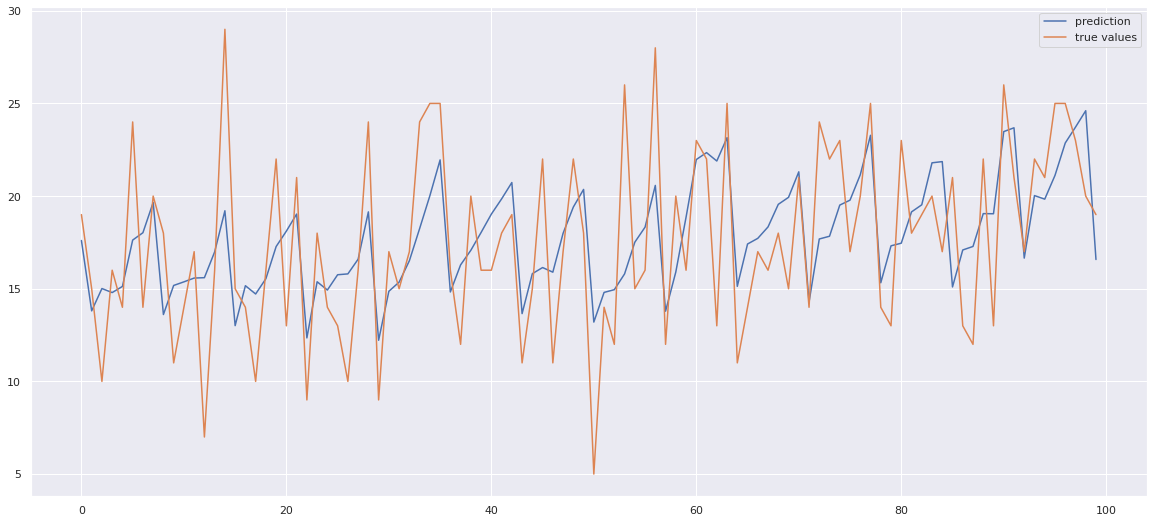

In [43]:
plt.plot(preds2[:100], label="prediction")
plt.plot(y_test.to_numpy()[:100], label="true values")
plt.legend()

Much better, but there's still room for improvement.

# Future improvements

* Further analysis - yearly, monthly trends per store/item
* Smarter way for hyperparameter tuning
* Cross-validation
* Different kind of model (e.g. neural-net based)
* Implement measures for evaluation